# 经典卷积网络(一) VGG

本文，我们将通过三个经典卷积网络：VGG、ResNet、DenseNet的关键点描述和代码复现，来学习经典卷积网络的思路

第一个部分，先来看看结构简单的VGGnet
整体的思路是，通过重复使用简单的基础块来构建深度模型


### 1、VGG块

连续使用相同的个数为1、窗口形状为3/*3的卷积层后接上一个stride为2、窗口形状为2/*2的最大池化层

卷积层保持输入的高和宽不变，池化层对其减半

对于给定的感受野，采用小卷积核优于采用大的卷积核，因为可以增加网络深度来保证学习更加复杂的模式，而且参数量少

例如，在VGG中使用3个3/*3代替 7/*7，使用两个3/*3代替5/*5，在保证具有相同感受野的情况下，参数量更少，且提升了网络深度

In [2]:
import time
import torch 
from torch import nn, optim

def vgg_block(num_convs, in_channels, out_channels):
    blk = []
    for i in range(num_convs):
        if i == 0:
            blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        else:
            blk.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.ReLU())
    blk.append(nn.MaxPool2d(kernel_size=3, stride=2)) 
    return nn.Sequential(*blk)

### 2、VGG网络
VGG网络获得了2014年的ImageNet ILSVRC冠军

由卷积层模块外界全连接模块构成，卷积层串联数个vgg_block，其参数量由变量conv_arch定义 该变量制定了每个VGG块里卷积层个数和输入输出通道数

其全连接层就是拍平+fc+fc

作者提出了几种不同配置的网络配置，分别为VGG11-VGG19
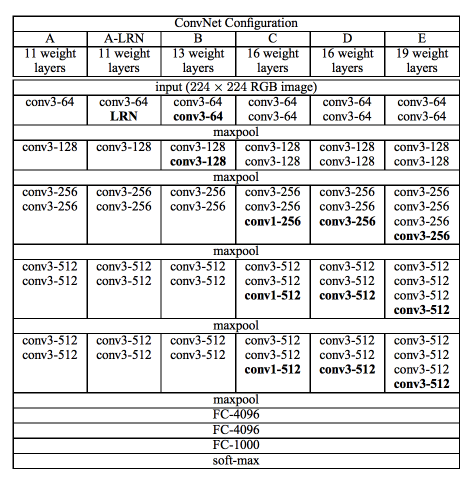


VGG网络不通配置之间的结构相同，为此我们首先定义一个可扩展的VGG类，作为各个配置VGG网络的框架，其中需要包含分类器，Avgpopl为7*7

In [30]:

class VGG(nn.Module):
    def __init__(self, features, num_class, init_weights):
        super(VGG, self).__init__()
        self.features = features  # 这里就传入卷积块即可，不同配置生成不同
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))  # 自适应平均池化，输出为7*7
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.Dropout(),  # 这里添加了Dropout
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_class)
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # 这里很关键，送如全连接层前需要拍平
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # 卷积层使用kaiming_normal初始化
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                # BN层初始化
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


接下来我们使用一个配置文件，存储VGG网络中所有的结构，这里主要记录每个VGG块里卷积层个数、输入、输出通道数


In [31]:
cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

这里使用make_layers方法读取配置文件


我们在其中增加bn层的控制来决定是否使用bn

In [32]:
def make_layers(cfg, batch_norm=False):
    # 这里的cfg就是上文cfgs中的一项
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            # maxpooling层
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = int(v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)
        

接下来，我们来通过构造的这些配合和工具方法，生成一个最为常用的结构：带BN层的VGG16网络


In [33]:
from torchvision.models.utils import load_state_dict_from_url
def vgg16_bn(pretrained=False, num_class=1000):
    kwargs = {}
    kwargs['num_class']  = num_class 
    features = make_layers(cfg=cfgs['D'], batch_norm=True)  # VGG16的配置是通道数从64-512， 2 2 3 3 3个卷积层
    if pretrained:
        kwargs['init_weights'] = False
        model = VGG(features, **kwargs)
        state_dict = load_state_dict_from_url('https://download.pytorch.org/models/vgg16_bn-6c64b313.pth')
        model.load_state_dict(state_dict)
    else:
        kwargs['init_weights'] = True
        model = VGG(features, **kwargs)
    return model

至此，已经完成VGG16的模型构建，接下来可以使用啦

让我们来检查一下模型结果

In [34]:
model = vgg16_bn()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [35]:
x = torch.rand((1, 3, 224, 224))
y = model(x)
y.size()

torch.Size([1, 1000])